In [600]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler

from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor


from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [601]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [602]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang','BR Vũng Tàu']

In [603]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [604]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [605]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [606]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [607]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [608]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [609]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [610]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y)

In [611]:
def train_and_evaluate(df_train, df_eval, model, feature_list , labels, scaler, is_dl_algo,nstep):
  """
  $df: pandas.DataFrame object containing data for training and testing model:
  $model: darts model object
  $feature_list: Names of the features used as model input
  $label: the value the model will be trained to predict
  $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
  $lags: how much to look back into the past to output prediction
  $split_index: the point at which to divide train and test_data

  """

  if is_dl_algo == 1:
    print("🍋")
  else:
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)

    df_eval = df_eval[-args.test_size - args.look_back-(nstep - 1): ]

    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    model.fit(y_train, past_covariates = x_train)

    prediction = model.predict(args.test_size, past_covariates = x_test, num_samples=1)

    df_eval = df_eval[-args.test_size:]
    y_true = df_eval[labels].values
    df_eval[labels]= np.array(prediction._xa).squeeze()
    y_pred = scaler.inverse_transform(df_eval.iloc[:,:-1])[:,[-1]].reshape(len(prediction))


    df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mse**0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"mean_squared_error: {mse:.4f}")
    print(f"rmse: {rmse}")
    print(f"mape: {mape}")
    return model, y_true, y_pred, mse, mae, rmse, mape

In [612]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler, is_dl_algo, nstep):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, prediction_inverse, mse, mae, rmse, mape = train_and_evaluate(df_train, df_eval, model, feature_list, labels, scaler,is_dl_algo,nstep)
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-len(prediction_inverse):],
                                  "Observed": y_true[-len(prediction_inverse):],
                                  f"{nstep}-month": prediction_inverse})
    

    df_prediction["City"] = location
    df_prediction[f"RMSE_{nstep}-month"] = rmse
    df_prediction[f"MAE_{nstep}-month"] = mae
    df_prediction[f"MAPE_{nstep}-month"] = mape
    df_prediction[f"MSE_{nstep}-month"] = mse

    temp_rs = f"{rmse},{mae},{mape},{mse}"
    print("rmse,mae,mape,mse")
    print(temp_rs)
    
    return df_prediction, model

In [613]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv", encoding = 'unicode_escape')
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [614]:
def getHyperParams(model_name, city, nstep):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_{nstep}-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  display(df_optimized)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

In [615]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [616]:
cities

['An Giang', 'BR Vũng Tàu']

✨✨✨✨✨✨✨✨1✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,15.337717,1,3,"-1,-2,-3",1,127,6,39
1,BR Vũng Tàu,RandomForest,16.891822,1,3,"-1,-2,-3",1,145,3,4


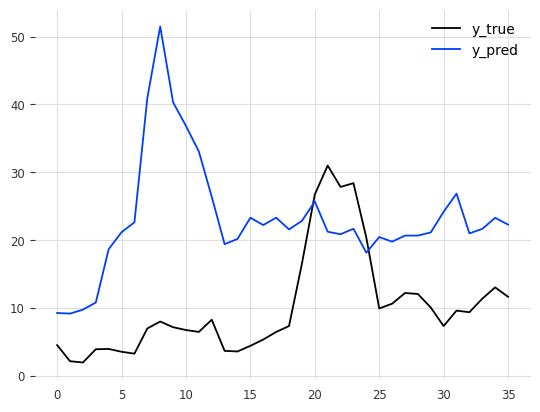

mean_squared_error: 292.6269
rmse: 17.10634079940464
mape: 2.3429341912238684
rmse,mae,mape,mse
17.10634079940464,14.441704010341656,2.3429341912238684,292.6268955453759
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,15.337717,1,3,"-1,-2,-3",1,127,6,39
1,BR Vũng Tàu,RandomForest,16.891822,1,3,"-1,-2,-3",1,145,3,4


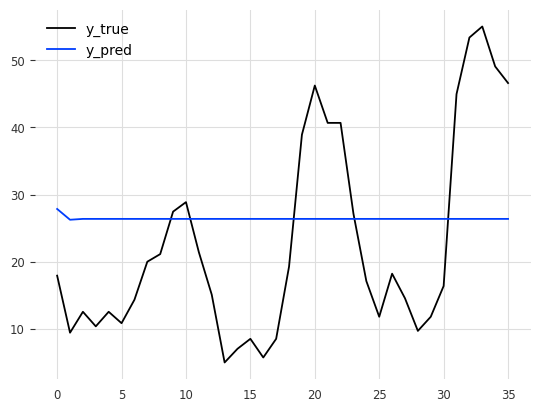

mean_squared_error: 234.8524
rmse: 15.324894372846655
mape: 0.9890043724783725
rmse,mae,mape,mse
15.324894372846655,13.821683993148955,0.9890043724783725,234.8523875389071
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,15
1,BR Vũng Tàu,LinearRegressionModel,18.555054,1,3,"-1,-2,-3",1,20


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


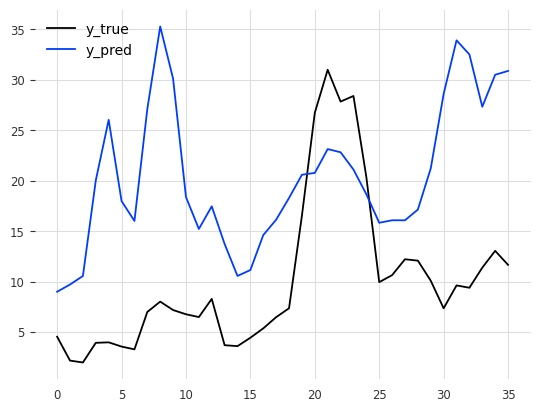

mean_squared_error: 184.7688
rmse: 13.592970349615078
mape: 1.864611516690918
rmse,mae,mape,mse
13.592970349615078,11.768939375892574,1.864611516690918,184.76884292551466
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,9.793240,1,3,"-1,-2,-3",1,15
1,BR Vũng Tàu,LinearRegressionModel,18.555054,1,3,"-1,-2,-3",1,20


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


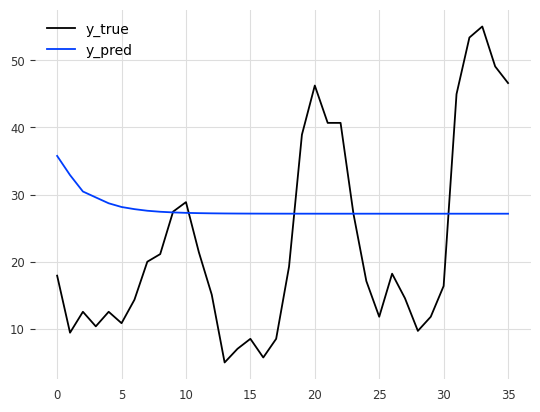

mean_squared_error: 262.0951
rmse: 16.189350708985838
mape: 1.0784701188426695
rmse,mae,mape,mse
16.189350708985838,14.707681312658972,1.0784701188426695,262.0950763785402
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,9,quantile
1,BR Vũng Tàu,XGBModel,61.708311,1,3,"-1,-2,-3",1,19,quantile


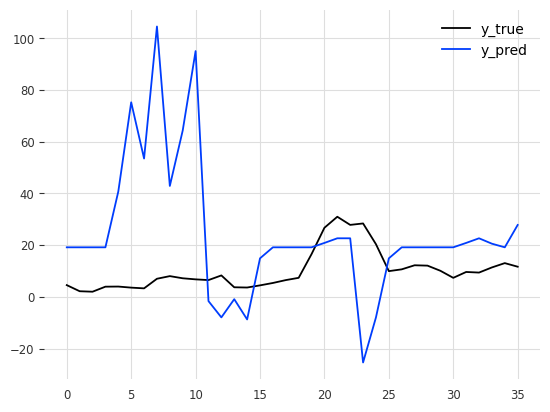

mean_squared_error: 1052.6362
rmse: 32.44435536364024
mape: 3.831969991196966
rmse,mae,mape,mse
32.44435536364024,22.199818214297075,3.831969991196966,1052.6361949621712
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,35.617705,1,3,"-1,-2,-3",1,9,quantile
1,BR Vũng Tàu,XGBModel,61.708311,1,3,"-1,-2,-3",1,19,quantile


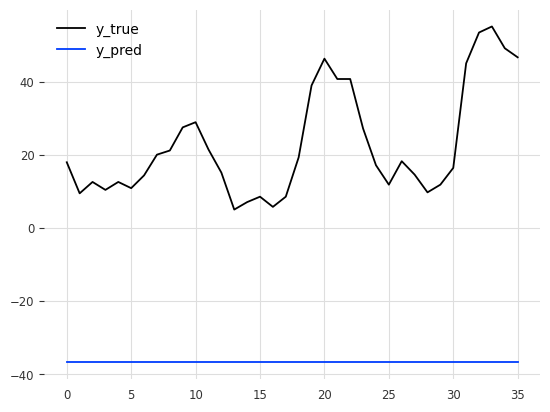

mean_squared_error: 3763.1848
rmse: 61.344802524161494
mape: 3.4643800390780153
rmse,mae,mape,mse
61.344802524161494,59.516862864176055,3.4643800390780153,3763.18479672837
✨✨✨✨✨✨✨✨2✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,8.033105,1,4,"-2,-3,-4",1,104,8,39
1,BR Vũng Tàu,RandomForest,19.015310,1,4,"-2,-3,-4",1,124,9,0


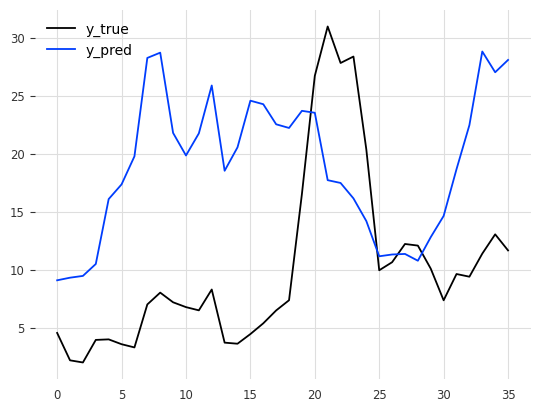

mean_squared_error: 165.5798
rmse: 12.867782874089963
mape: 1.8592847633210599
rmse,mae,mape,mse
12.867782874089963,11.358823919567234,1.8592847633210599,165.57983609472296
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,8.033105,1,4,"-2,-3,-4",1,104,8,39
1,BR Vũng Tàu,RandomForest,19.015310,1,4,"-2,-3,-4",1,124,9,0


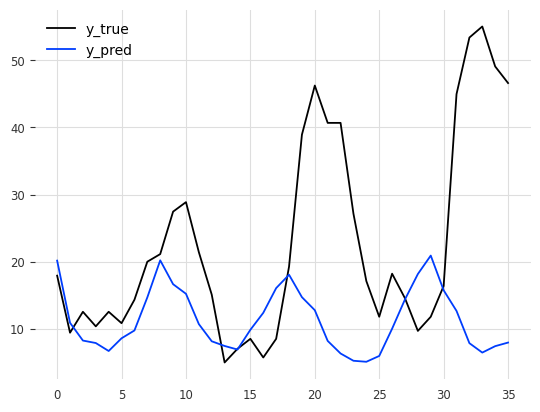

mean_squared_error: 394.8337
rmse: 19.870422823349756
mape: 0.5005744306456315
rmse,mae,mape,mse
19.870422823349756,13.561466415731884,0.5005744306456315,394.8337031786989
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,36
1,BR Vũng Tàu,LinearRegressionModel,18.319899,1,4,"-2,-3,-4",1,2


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


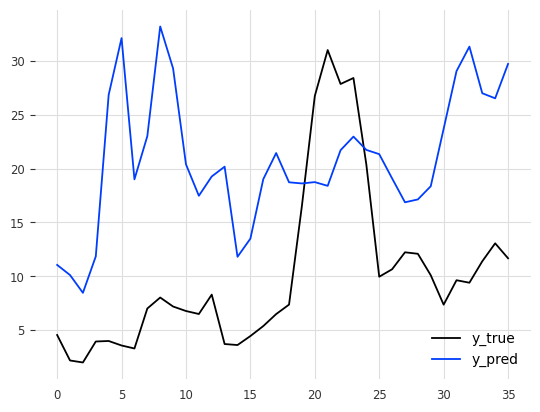

mean_squared_error: 195.5684
rmse: 13.984577150904904
mape: 2.0226315379199753
rmse,mae,mape,mse
13.984577150904904,12.402518518473059,2.0226315379199753,195.56839808961155
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,10.967351,1,4,"-2,-3,-4",1,36
1,BR Vũng Tàu,LinearRegressionModel,18.319899,1,4,"-2,-3,-4",1,2


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


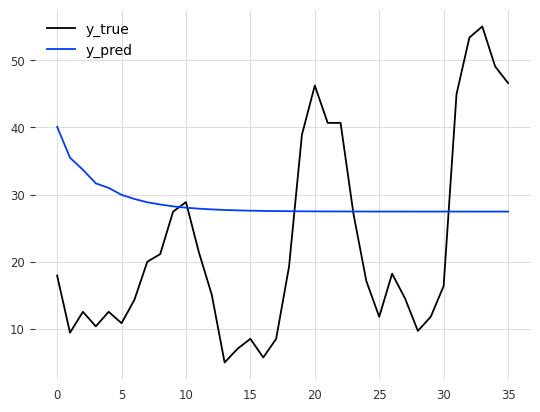

mean_squared_error: 284.4008
rmse: 16.86418694660479
mape: 1.1362310312958912
rmse,mae,mape,mse
16.86418694660479,15.361915567858283,1.1362310312958912,284.4008013700354
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,26,quantile
1,BR Vũng Tàu,XGBModel,60.807202,1,4,"-2,-3,-4",1,28,quantile


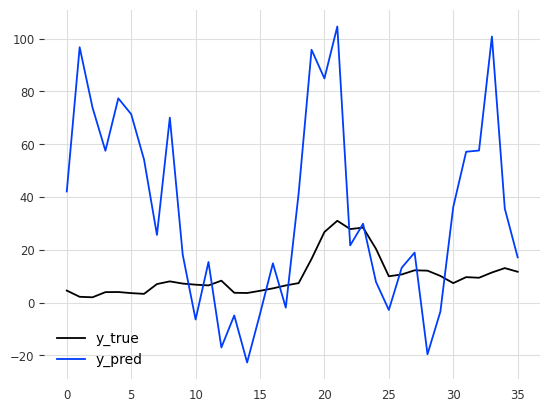

mean_squared_error: 1916.6461
rmse: 43.77951661911574
mape: 6.443460109785577
rmse,mae,mape,mse
43.77951661911574,34.02859574003378,6.443460109785577,1916.646075403431
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,62.941766,1,4,"-2,-3,-4",1,26,quantile
1,BR Vũng Tàu,XGBModel,60.807202,1,4,"-2,-3,-4",1,28,quantile


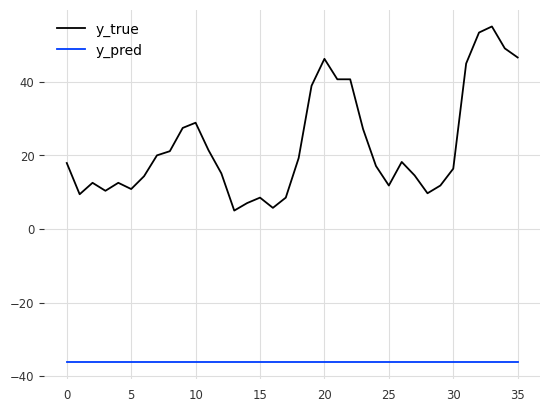

mean_squared_error: 3703.9186
rmse: 60.859827807797345
mape: 3.4308767948013723
rmse,mae,mape,mse
60.859827807797345,59.016868853400815,3.4308767948013723,3703.9186407947427
✨✨✨✨✨✨✨✨3✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,10.142172,1,5,"-3,-4,-5",1,91,4,7
1,BR Vũng Tàu,RandomForest,18.149845,1,5,"-3,-4,-5",1,106,10,26


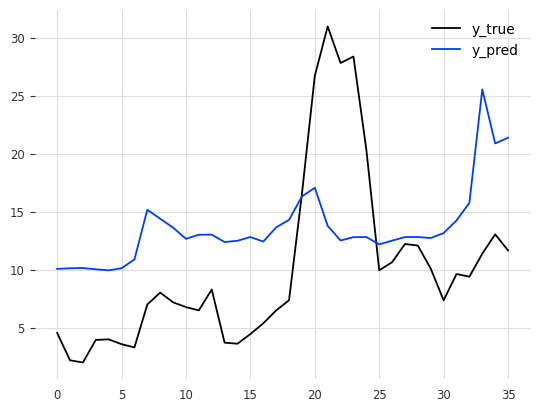

mean_squared_error: 65.2739
rmse: 8.079228953796864
mape: 1.0910201078576405
rmse,mae,mape,mse
8.079228953796864,7.091068379127991,1.0910201078576405,65.27394048786958
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,10.142172,1,5,"-3,-4,-5",1,91,4,7
1,BR Vũng Tàu,RandomForest,18.149845,1,5,"-3,-4,-5",1,106,10,26


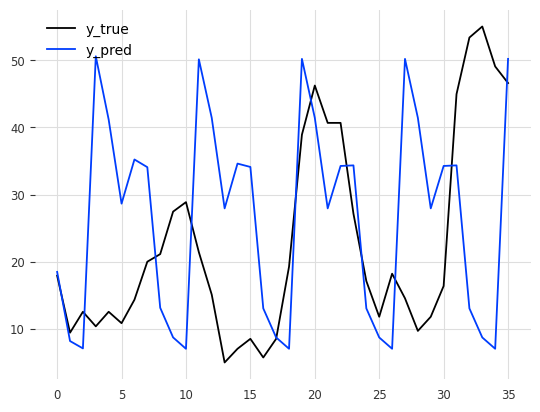

mean_squared_error: 473.6761
rmse: 21.764102288532957
mape: 1.168492114002345
rmse,mae,mape,mse
21.764102288532957,17.59406456800467,1.168492114002345,473.67614842572556
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,5
1,BR Vũng Tàu,LinearRegressionModel,18.036329,1,5,"-3,-4,-5",1,23


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


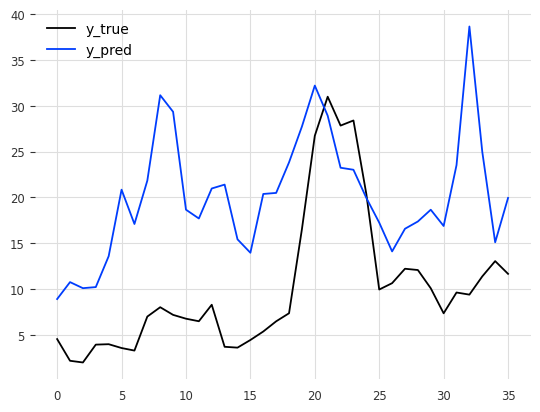

mean_squared_error: 152.3325
rmse: 12.342304492031591
mape: 1.788989555655957
rmse,mae,mape,mse
12.342304492031591,10.645827807948233,1.788989555655957,152.3324801740232
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,10.325255,1,5,"-3,-4,-5",1,5
1,BR Vũng Tàu,LinearRegressionModel,18.036329,1,5,"-3,-4,-5",1,23


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


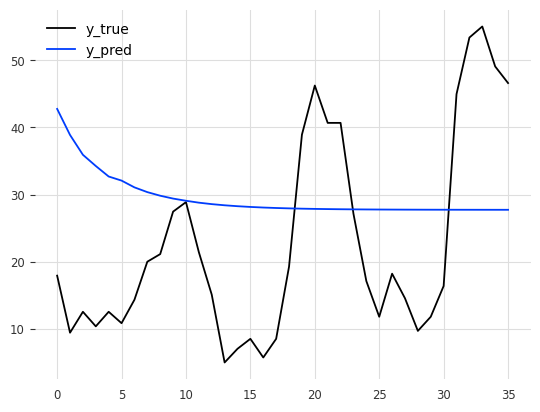

mean_squared_error: 309.4585
rmse: 17.591432249404097
mape: 1.1971109667911655
rmse,mae,mape,mse
17.591432249404097,16.035956916775156,1.1971109667911655,309.4584885853745
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,11,quantile
1,BR Vũng Tàu,XGBModel,60.776181,1,5,"-3,-4,-5",1,11,quantile


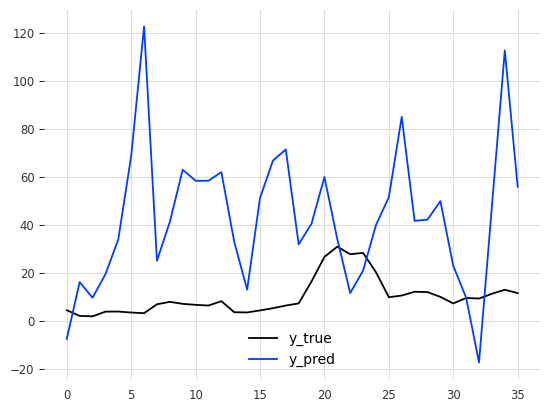

mean_squared_error: 1994.4614
rmse: 44.65939283012492
mape: 5.7112491528461184
rmse,mae,mape,mse
44.65939283012492,36.3044755885307,5.7112491528461184,1994.4613679554136
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,19.292724,1,5,"-3,-4,-5",1,11,quantile
1,BR Vũng Tàu,XGBModel,60.776181,1,5,"-3,-4,-5",1,11,quantile


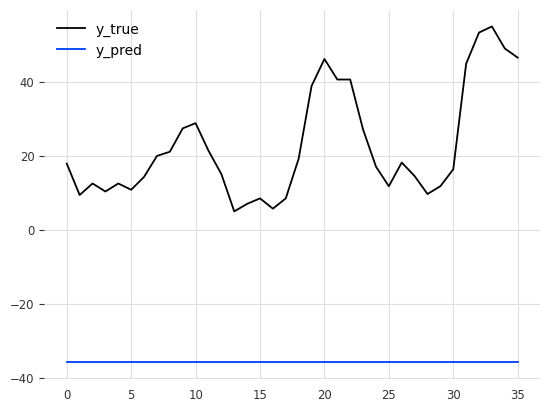

mean_squared_error: 3656.7049
rmse: 60.47069429603146
mape: 3.403982267685494
rmse,mae,mape,mse
60.47069429603146,58.61550167923891,3.403982267685494,3656.704868644092
✨✨✨✨✨✨✨✨4✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,10.109302,1,6,"-4,-5,-6",1,115,4,30
1,BR Vũng Tàu,RandomForest,17.788164,1,6,"-4,-5,-6",1,194,7,37


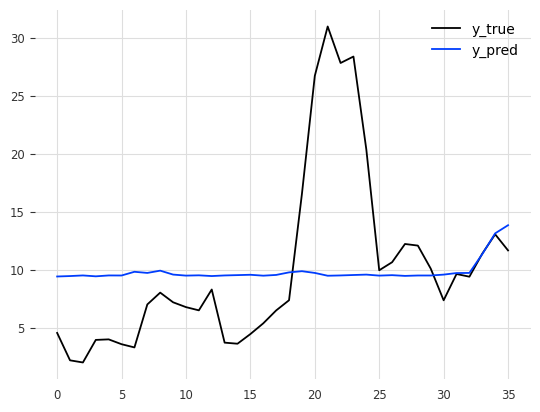

mean_squared_error: 57.3304
rmse: 7.571686319461248
mape: 0.7569379092304149
rmse,mae,mape,mse
7.571686319461248,5.251807402651621,0.7569379092304149,57.33043372031663
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,10.109302,1,6,"-4,-5,-6",1,115,4,30
1,BR Vũng Tàu,RandomForest,17.788164,1,6,"-4,-5,-6",1,194,7,37


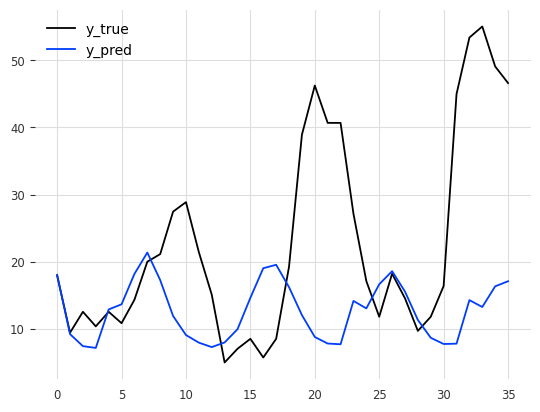

mean_squared_error: 347.1714
rmse: 18.632535463091838
mape: 0.5097808747443512
rmse,mae,mape,mse
18.632535463091838,12.888390562263835,0.5097808747443512,347.1713777833749
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,19
1,BR Vũng Tàu,LinearRegressionModel,17.863237,1,6,"-4,-5,-6",1,38


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


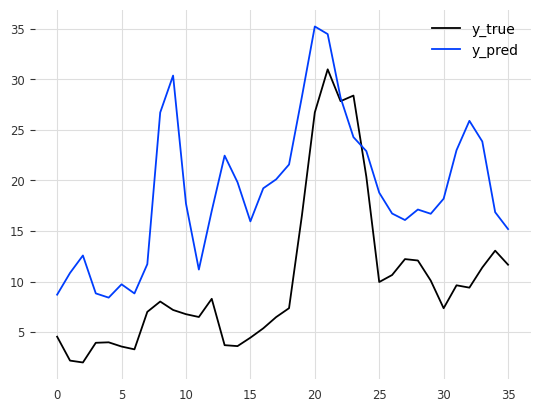

mean_squared_error: 110.1778
rmse: 10.496559853154205
mape: 1.5245214216082605
rmse,mae,mape,mse
10.496559853154205,9.033686158145969,1.5245214216082605,110.17776875084863
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,12.048996,1,6,"-4,-5,-6",1,19
1,BR Vũng Tàu,LinearRegressionModel,17.863237,1,6,"-4,-5,-6",1,38


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


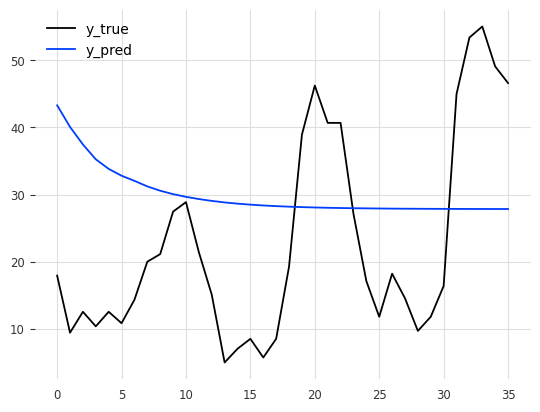

mean_squared_error: 321.8988
rmse: 17.94153713933533
mape: 1.2278018488261273
rmse,mae,mape,mse
17.94153713933533,16.388367951256033,1.2278018488261273,321.898754922149
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,17,quantile
1,BR Vũng Tàu,XGBModel,60.257188,1,6,"-4,-5,-6",1,42,quantile


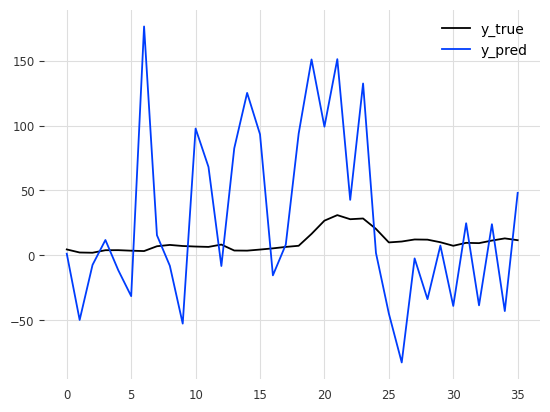

mean_squared_error: 4442.0243
rmse: 66.64851297459367
mape: 7.933711740345583
rmse,mae,mape,mse
66.64851297459367,51.07209476622929,7.933711740345583,4442.024281724581
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,42.195607,1,6,"-4,-5,-6",1,17,quantile
1,BR Vũng Tàu,XGBModel,60.257188,1,6,"-4,-5,-6",1,42,quantile


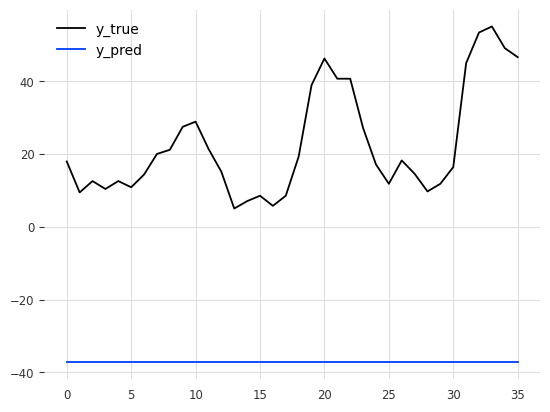

mean_squared_error: 3825.2964
rmse: 61.84898081655813
mape: 3.4991924087110857
rmse,mae,mape,mse
61.84898081655813,60.03639393327805,3.4991924087110857,3825.296428046976
✨✨✨✨✨✨✨✨5✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,9.925405,1,7,"-5,-6,-7",1,157,12,9
1,BR Vũng Tàu,RandomForest,16.787485,1,7,"-5,-6,-7",1,53,1,38


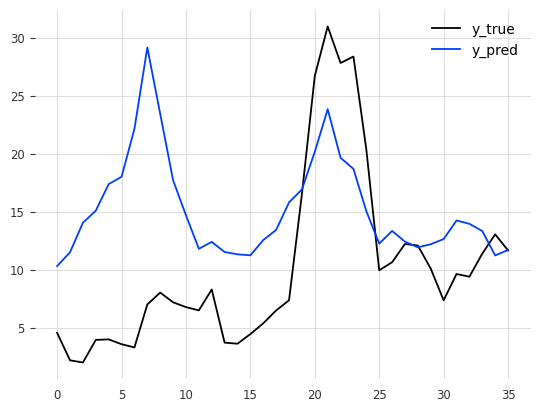

mean_squared_error: 77.7597
rmse: 8.818147599610658
mape: 1.3899581640863927
rmse,mae,mape,mse
8.818147599610658,7.179723603532927,1.3899581640863927,77.7597270885192
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,9.925405,1,7,"-5,-6,-7",1,157,12,9
1,BR Vũng Tàu,RandomForest,16.787485,1,7,"-5,-6,-7",1,53,1,38


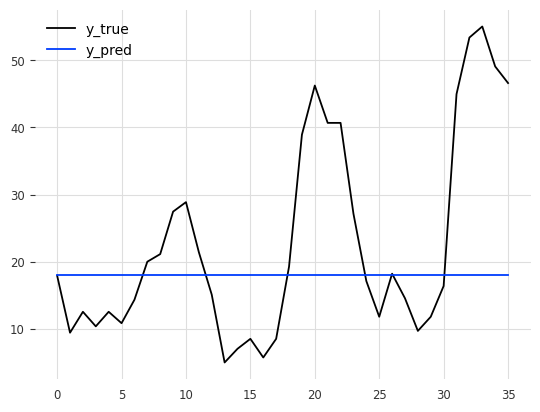

mean_squared_error: 242.6244
rmse: 15.576405274064198
mape: 0.5974916687680135
rmse,mae,mape,mse
15.576405274064198,11.553596983804084,0.5974916687680135,242.62440126189495
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,11
1,BR Vũng Tàu,LinearRegressionModel,17.735793,1,7,"-5,-6,-7",1,2


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


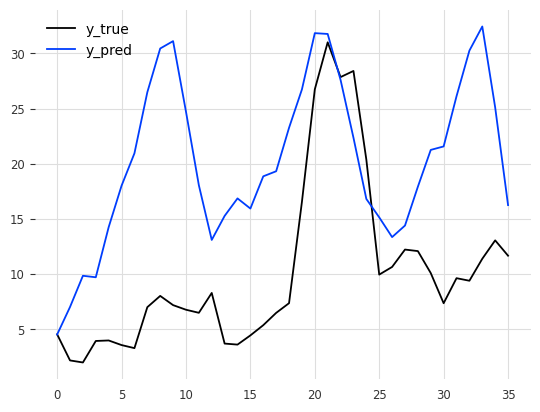

mean_squared_error: 155.8036
rmse: 12.482130315448206
mape: 1.7307355461402052
rmse,mae,mape,mse
12.482130315448206,10.599352955078263,1.7307355461402052,155.8035772118311
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,9.455692,1,7,"-5,-6,-7",1,11
1,BR Vũng Tàu,LinearRegressionModel,17.735793,1,7,"-5,-6,-7",1,2


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


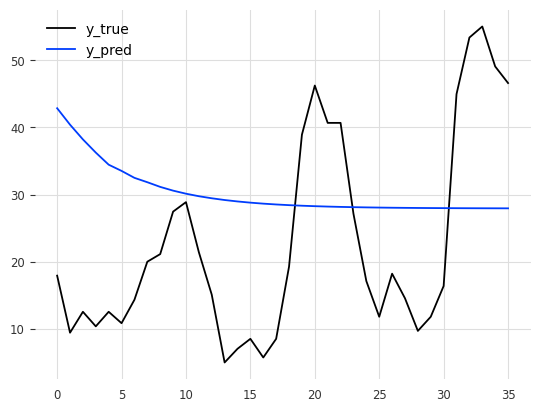

mean_squared_error: 329.1518
rmse: 18.142541826265322
mape: 1.2482550839497057
rmse,mae,mape,mse
18.142541826265322,16.608977987850384,1.2482550839497057,329.15182391778666
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,24,quantile
1,BR Vũng Tàu,XGBModel,62.033699,1,7,"-5,-6,-7",1,22,quantile


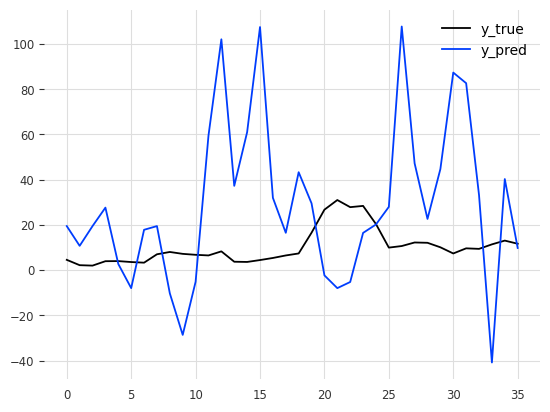

mean_squared_error: 1778.1888
rmse: 42.16857575766047
mape: 4.732498209924145
rmse,mae,mape,mse
42.16857575766047,32.32510303851208,4.732498209924145,1778.1887814295505
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,39.323421,1,7,"-5,-6,-7",1,24,quantile
1,BR Vũng Tàu,XGBModel,62.033699,1,7,"-5,-6,-7",1,22,quantile


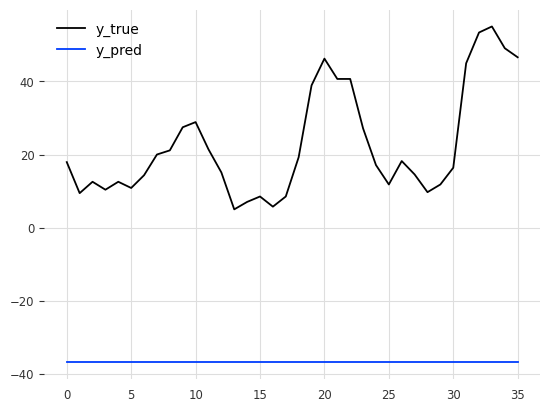

mean_squared_error: 3775.7604
rmse: 61.447216490474624
mape: 3.47145292116722
rmse,mae,mape,mse
61.447216490474624,59.62241678171077,3.47145292116722,3775.7604144272564
✨✨✨✨✨✨✨✨6✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨RandomForest✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,26.152213,1,8,"-6,-7,-8",1,73,13,16
1,BR Vũng Tàu,RandomForest,17.034018,1,8,"-6,-7,-8",1,152,3,39


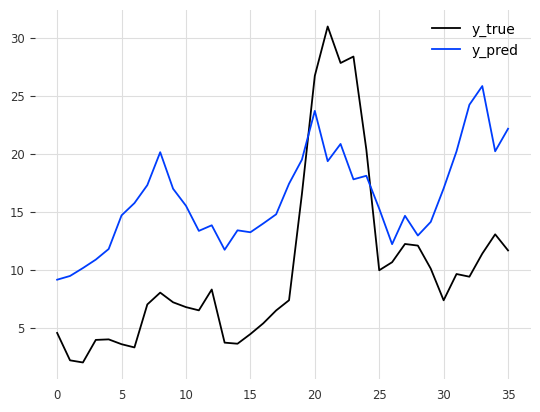

mean_squared_error: 74.5222
rmse: 8.632626608039384
mape: 1.3045236213568416
rmse,mae,mape,mse
8.632626608039384,7.893332474382188,1.3045236213568416,74.52224215382957
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,n_estimators,max_depth,random_state
0,An Giang,RandomForest,26.152213,1,8,"-6,-7,-8",1,73,13,16
1,BR Vũng Tàu,RandomForest,17.034018,1,8,"-6,-7,-8",1,152,3,39


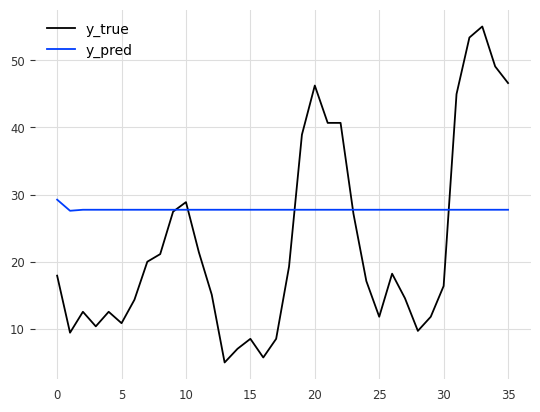

mean_squared_error: 246.7255
rmse: 15.707499702593022
mape: 1.0588878751189041
rmse,mae,mape,mse
15.707499702593022,14.32405734534502,1.0588878751189041,246.72554690695986
✨✨✨✨✨✨✨✨LinearRegressionModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,4
1,BR Vũng Tàu,LinearRegressionModel,17.551700,1,8,"-6,-7,-8",1,4


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


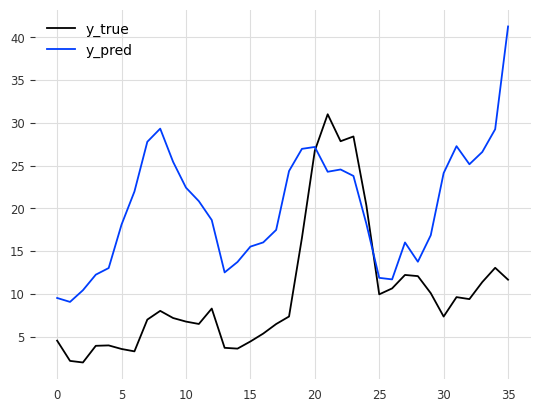

mean_squared_error: 164.5409
rmse: 12.827349620781282
mape: 1.7705520705528868
rmse,mae,mape,mse
12.827349620781282,10.950017987954766,1.7705520705528868,164.54089829375772
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state
0,An Giang,LinearRegressionModel,8.749062,1,8,"-6,-7,-8",1,4
1,BR Vũng Tàu,LinearRegressionModel,17.551700,1,8,"-6,-7,-8",1,4


💫💫💫💫💫Params nek💫💫💫💫💫💫💫
output_chunk_length:  1


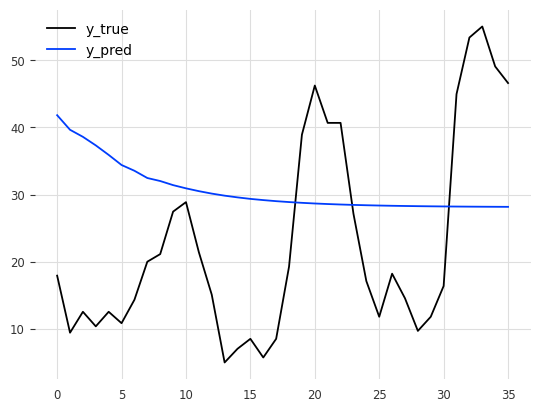

mean_squared_error: 337.4680
rmse: 18.37030172346271
mape: 1.2767990095834696
rmse,mae,mape,mse
18.37030172346271,16.90042867967082,1.2767990095834696,337.46798541105704
✨✨✨✨✨✨✨✨XGBModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,35,quantile
1,BR Vũng Tàu,XGBModel,61.515563,1,8,"-6,-7,-8",1,28,quantile


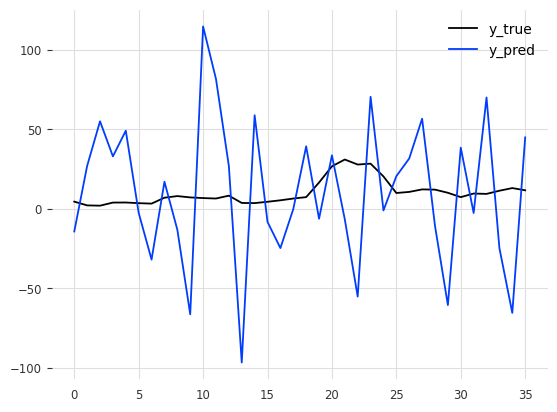

mean_squared_error: 2199.5466
rmse: 46.899323628193144
mape: 6.143344982536135
rmse,mae,mape,mse
46.899323628193144,38.60241573587473,6.143344982536135,2199.546556781996
✨✨✨✨✨✨✨✨BR Vũng Tàu✨✨✨✨✨✨✨✨✨✨


,City,Alg_name,Best_value,n_try_opt,lags,lags_past_covariates,output_chunk_length,random_state,likelihood
0,An Giang,XGBModel,36.817075,1,8,"-6,-7,-8",1,35,quantile
1,BR Vũng Tàu,XGBModel,61.515563,1,8,"-6,-7,-8",1,28,quantile


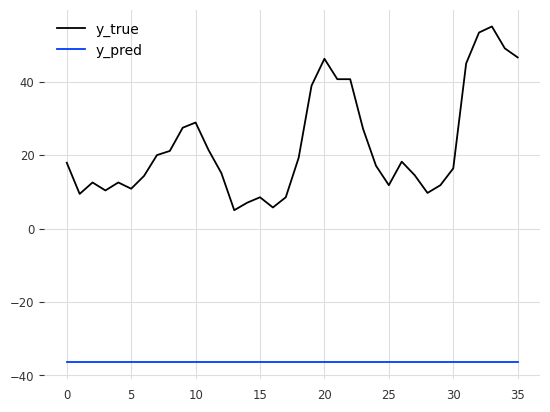

mean_squared_error: 3726.1073
rmse: 61.04184838232787
mape: 3.443453185811533
rmse,mae,mape,mse
61.04184838232787,59.20455575710261,3.443453185811533,3726.107253931104


In [617]:
model_name_list = [
     "RandomForest",
     "LinearRegressionModel",
    #  "LightGBMModel",
    #  "CatBoostModel",
     "XGBModel",
    # "PoissonRegressor",
    # "SVMRBF"
]

# for nstep in range(1,args.n_predicted_period_months+1):
for nstep in range(1,args.n_predicted_period_months+1):
    print(f"✨✨✨✨✨✨✨✨{nstep}✨✨✨✨✨✨✨✨✨✨")
    for model_name in model_name_list:   
        print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
        for city in cities:
            print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
            df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            df_valid = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
            scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok

            selected_features = getDataWithSelectedFeature(city, nstep)

            lags_by_nstep = args.look_back + nstep - 1
            lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
            is_dl_algo = 0

            pl_trainer_kwargs = {
                        "accelerator": "cpu",
                        # "devices": -1,
                        # "auto_select_gpus": True,
                    }

            df_hyper_params = getHyperParams(model_name, city, nstep)

            if model_name == "RandomForest":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    # Create the RandomForest model
                    model = RandomForest(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates_by_nstep,
                                    output_chunk_length = int(output_chunk_length),
                                    n_estimators = int(n_estimators),
                                    max_depth = int(max_depth),
                                    random_state=int(random_state))
            elif model_name == 'XGBModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    # Create the  model
                    model = XGBModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state),
                                    likelihood = likelihood
                                    )
            elif model_name == 'LinearRegressionModel':
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    print("💫💫💫💫💫Params nek💫💫💫💫💫💫💫")
                    print("output_chunk_length: ",output_chunk_length)
                    # Create the  model
                    model = LinearRegressionModel(
                                    lags = int(lags),
                                    lags_past_covariates = lags_past_covariates,
                                    output_chunk_length = int(output_chunk_length),
                                    random_state=int(random_state))
            elif model_name == "CatBoostModel":
                    print("Tới đây chưa má nội")
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    n_estimators = df_hyper_params['n_estimators'].values[0]
                    max_depth = df_hyper_params['max_depth'].values[0]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    quantiles =  df_hyper_params['quantiles'].values[0]
                    bagging_temperature = df_hyper_params['bagging_temperature'].values[0]
                    border_count = df_hyper_params['border_count'].values[0]
                    l2_leaf_reg = df_hyper_params['l2_leaf_reg'].values[0]
                    random_strength = df_hyper_params['random_strength'].values[0]
                    model = CatBoostModel(
                                            lags=int(lags),
                                            lags_past_covariates=lags_past_covariates, 
                                            learning_rate=float(learning_rate),
                                            n_estimators= int(n_estimators),
                                            max_depth=int(max_depth), 
                                            output_chunk_length = int(output_chunk_length),
                                            likelihood = likelihood,
                                            # quantiles = float(quantiles), #None or float
                                            bagging_temperature = float(bagging_temperature),
                                            # border_count = int(border_count),
                                            l2_leaf_reg = float(l2_leaf_reg),
                                            random_strength = float(random_strength),
                                            random_state=int(random_state))
            elif model_name == "LightGBMModel":
                    lags = df_hyper_params['lags'].values[0]
                    lags_past_covariates = df_hyper_params['lags_past_covariates'].values[0].split(',')
                    lags_past_covariates = [int(i) for i in lags_past_covariates]
                    output_chunk_length = df_hyper_params['output_chunk_length'].values[0]
                    random_state = df_hyper_params['random_state'].values[0]
                    multi_models = df_hyper_params['multi_models'].values[0]
                    likelihood = df_hyper_params['likelihood'].values[0]
                    num_leaves = df_hyper_params['num_leaves'].values[0]
                    learning_rate = df_hyper_params['learning_rate'].values[0]
                    feature_fraction = df_hyper_params['feature_fraction'].values[0]
                    bagging_fraction = df_hyper_params['bagging_fraction'].values[0]
                    min_child_samples = df_hyper_params['min_child_samples'].values[0]
                    lambda_l1 = df_hyper_params['lambda_l1'].values[0]
                    verbose = df_hyper_params['verbose'].values[0]
                    model = LightGBMModel(
                        lags =int(lags),
                        lags_past_covariates = lags_past_covariates,
                        output_chunk_length = int(output_chunk_length),
                        random_state = int(random_state),
                        multi_models = bool(multi_models),
                        likelihood = likelihood,
                        num_leaves = int(num_leaves),
                        learning_rate = float(learning_rate),
                        feature_fraction = float(feature_fraction),
                        bagging_fraction = float(bagging_fraction),
                        min_child_samples = int(min_child_samples),
                        lambda_l1 = float(lambda_l1),
                        verbose = int(verbose)
                    )          
            df, model = output_prediction_for_location(df_train, df_valid, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler, is_dl_algo = is_dl_algo, nstep = nstep)
            df.to_excel(f"./predict_results/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
            pickle.dump(model, open(f"./trained_models/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))